In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.main import single_fitting_cycle
from main.seir.forecast import create_all_trials_csv, create_decile_csv_new
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logger import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.uncertainty import plot_beta_loss

import yaml
import wandb

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/wandb/util.py:35: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence


In [3]:
predictions_dict = {}

In [4]:
config_filename = 'mcmc_simulate.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [5]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform Fit

  0%|          | 6/2000 [00:00<00:38, 51.66it/s]

Performing fit ..
loading from ../../misc/cache/dataframes_ts_02042021_SimulatedDataLoader.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 43                  | 44                  | 45                  | 46                  | 47                  |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-24 00:00:00 | 2020-08-25 00:00:00 | 2020-08-26 00:00:00 | 2020-08-27 00:00:00 | 2020-08-28 00:00:00 |
| total       | 204722.0            | 205680.0            | 206612.0            | 207520.0            | 208405.0            |
| active      | 31730.0             | 31245.0             | 30756.0             | 30266.0             | 29775.0             |
| deceased    | 12743.0             | 12857.0             | 12970.0             | 13081.0             | 13

  0%|          | 8/2000 [00:00<00:25, 78.55it/s]

The acceptance ratio is -------->  0.146
The explored steps are -------->  13
The optimized steps are -------->  279
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0660427851513037,
    'I_hosp_ratio': 1.0025984249126096,
    'P_fatal': 1.2580072426507092,
    'T_inc': 1.4053090045655896,
    'T_inf': 2.709991019303681,
    'T_recov': 1.2387678201963814,
    'T_recov_fatal': 1.0182141280789787,
    'gamma': 1.0056430375125163,
    'lockdown_R0': 1.059503168762671}


100%|██████████| 2000/2000 [00:23<00:00, 86.34it/s] 


best parameters
 {'lockdown_R0': 0.8629983257324412, 'T_inc': 4.7579115222794615, 'T_inf': 3.660871386856277, 'T_recov': 18.742131481400385, 'T_recov_fatal': 2.9337899171503956, 'P_fatal': 0.02554554624050642, 'E_hosp_ratio': 0.16709841130068107, 'I_hosp_ratio': 0.242464573780578, 'gamma': 0.006495863303871147}


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


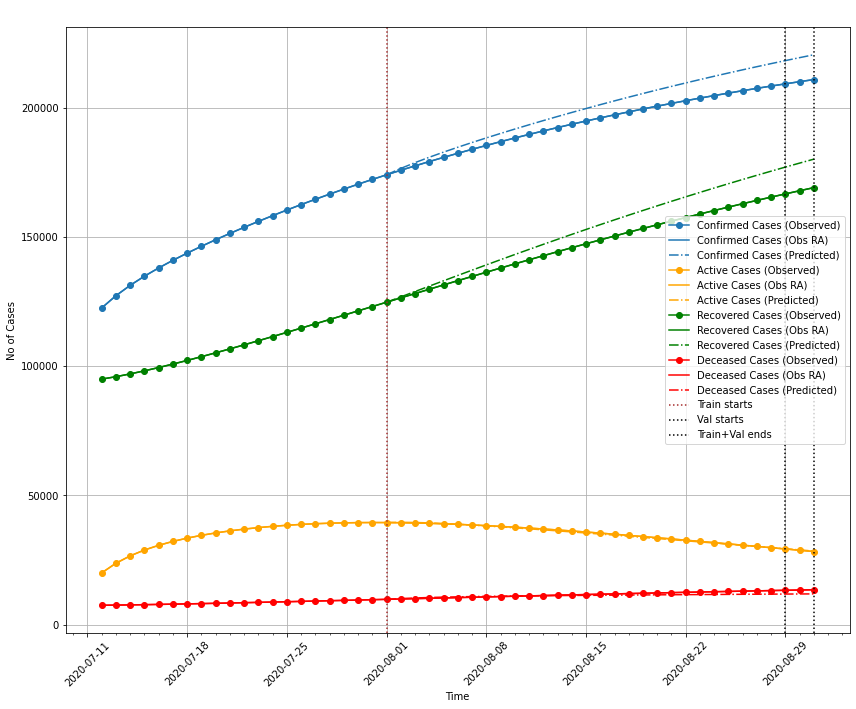

In [6]:
predictions_dict = single_fitting_cycle(**copy.deepcopy(config['fitting']))

## Loss Dataframe

{}

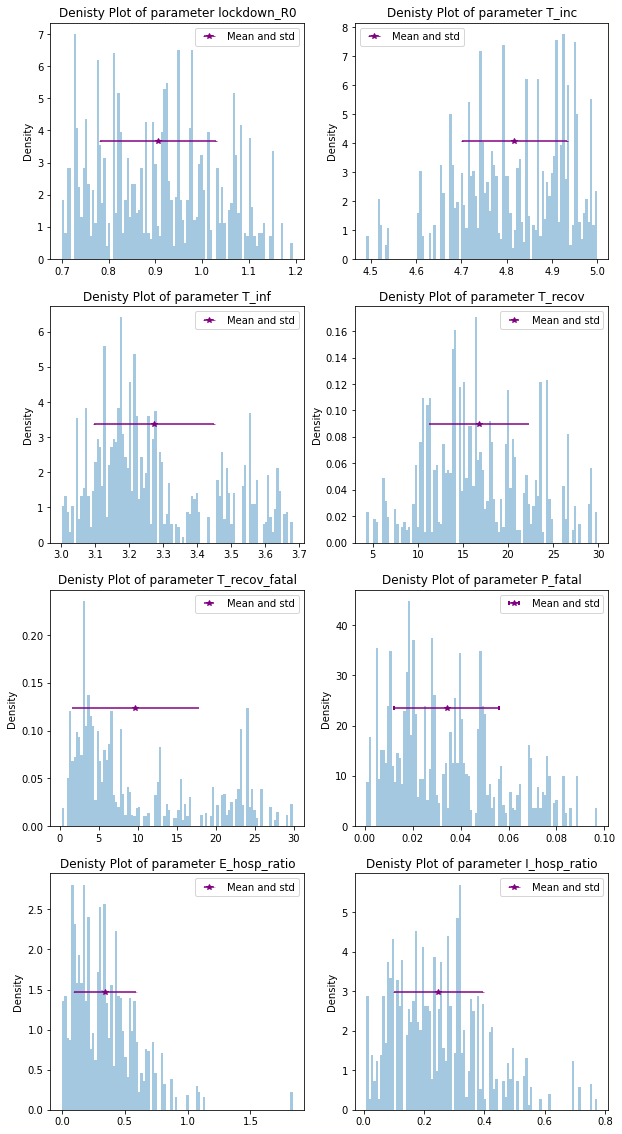

In [7]:
from viz.fit import plot_histogram
fig,axs = plt.subplots(4,2,figsize = (10,20))
plot_histogram(predictions_dict,fig = fig,axs=axs)

In [8]:
predictions_dict['df_loss']

,train,val,test
total,2.364663,4.426206,NaN
active,0.591441,0.463092,NaN
recovered,3.419813,6.370902,NaN
deceased,4.241576,11.415848,NaN


## Plot Best Forecast

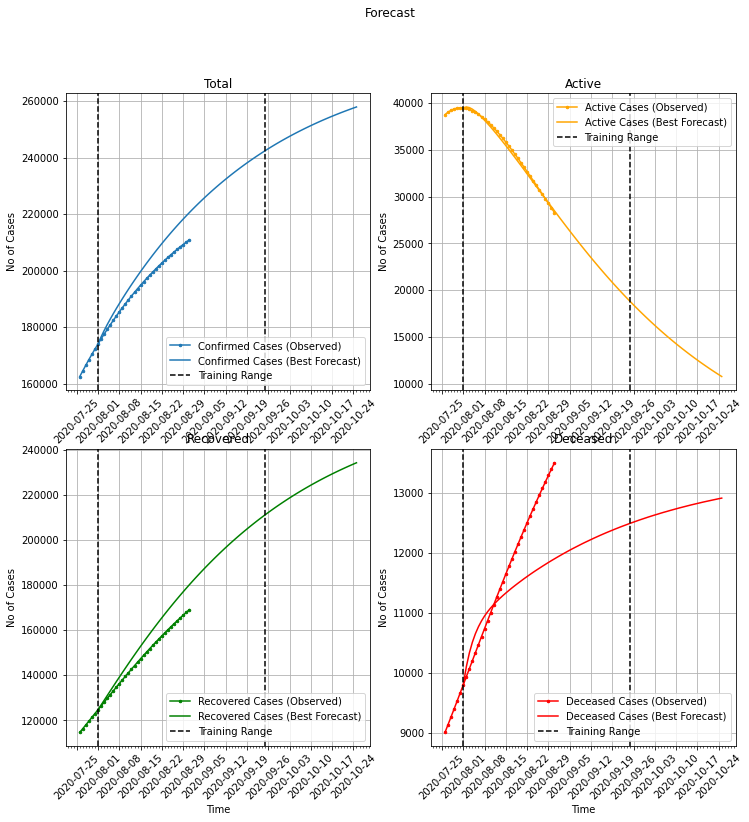

In [9]:
predictions_dict['forecasts'] = {}
predictions_dict['forecasts']['best'] = predictions_dict['trials']['predictions'][0]

predictions_dict['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                            which_compartments=config['fitting']['loss']['loss_compartments'],
                                                            error_bars=False, **config['plotting'])

## Process trials + Find best beta

In [10]:
uncertainty_args = {'predictions_dict': predictions_dict,  "variable_param_ranges" :config['fitting']['variable_param_ranges'],
                     **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

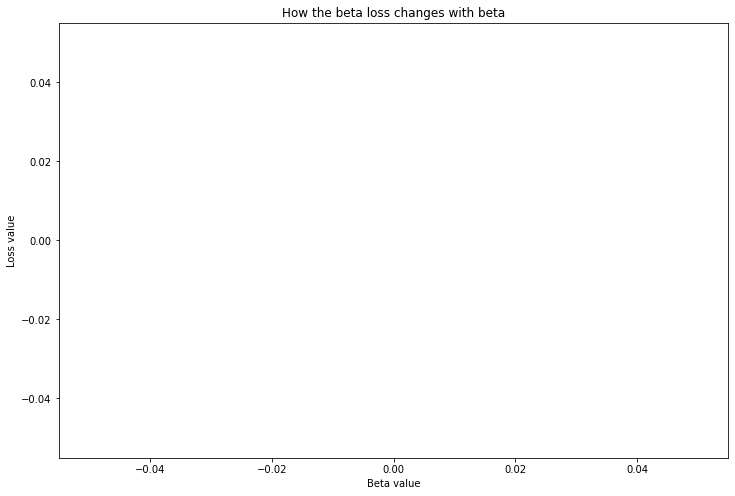

In [11]:
predictions_dict['plots']['beta_loss'], _ = plot_beta_loss(uncertainty.dict_of_trials)

In [13]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predicions_dict['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

NameError: name 'predicions_dict' is not defined

## Plot Top k Trials

In [ ]:
kforecasts = plot_top_k_trials(predictions_dict, k=config['plotting']['num_trials_to_plot'],
                               which_compartments=config['plotting']['plot_topk_trials_for_columns'])
                               
predictions_dict['plots']['forecasts_topk'] = {}
for column in config['plotting']['plot_topk_trials_for_columns']:
    predictions_dict['plots']['forecasts_topk'][column.name] = kforecasts[column]

In [ ]:
predictions_dict['beta'] = uncertainty.beta
predictions_dict['beta_loss'] = uncertainty.beta_loss
predictions_dict['deciles'] = uncertainty_forecasts

## Plot Deciles Forecasts

In [ ]:
for fits_to_plot in config['plotting']['pair_fits_to_plot']:
    predictions_dict['plots'][f'forecast_{fits_to_plot[0]}_{fits_to_plot[1]}'] = plot_forecast(
        predictions_dict, which_compartments=config['fitting']['loss']['loss_compartments'],
        fits_to_plot=fits_to_plot, **config['plotting'])

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['plotting']['plot_ptiles_for_columns'])
predictions_dict['plots']['forecasts_ptiles'] = {}
for column in config['plotting']['plot_ptiles_for_columns']:
    predictions_dict['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Log on MLFlow

In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)